In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
tokenizer = AutoTokenizer.from_pretrained("ISTA-DASLab/Llama-2-7b-AQLM-2Bit-2x8-hf")
model = AutoModelForCausalLM.from_pretrained("ISTA-DASLab/Llama-2-7b-AQLM-2Bit-2x8-hf")
%load_ext autoreload
%autoreload 2

/home/coralie/canada/Latent-truth-detector/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`low_cpu_mem_usage` was None, now set to True since model is quantized.


In [2]:
import os
import torch
device = 'cuda' if torch.cuda.is_available() else 'CPU'
print('Device: {} '.format(device))


Device: cuda 


In [3]:
model.to(device)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): QuantizedLinear()
          (k_proj): QuantizedLinear()
          (v_proj): QuantizedLinear()
          (o_proj): QuantizedLinear()
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): QuantizedLinear()
          (up_proj): QuantizedLinear()
          (down_proj): QuantizedLinear()
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head): Linear(in_features=4096, out_features=32000, bias=False)
)

In [4]:
activations = {}
def capture_output(module, input, output):
    activations['layer_13_output'] = output[0].detach()
    
hook = model.model.layers[13].register_forward_hook(capture_output)

In [5]:
input_text = "paris is in france"
input_token = tokenizer.encode_plus(input_text, return_tensors="pt")

input_ids = input_token["input_ids"].to(device)
mask = input_token["attention_mask"].to(device)

In [6]:
with torch.no_grad():
    output = model(input_ids=input_ids, attention_mask=mask)
    
layer_13_output = activations['layer_13_output'].to(device)
hook.remove()

In [7]:
layer_13_output.shape , input_ids

(torch.Size([1, 7, 4096]),
 tensor([[   1,  610,  275,  338,  297, 2524,  346]], device='cuda:0'))

- dimension 0 : taille du batch
- dimension 1 : taille de la séquence
- dimension 2 : taille de la représentation

On aura donc des tailles variables de sortie en fonction de la taille de la séquence d'entrée. 

Comment faire pour l'utiliser pour la classification ?

- utiliser le token `[CLS]` (modéle basé sur bert) qui est le premier token de la séquence (espece de représentation de la séquence entière) nous on est sur sententpiece `<s>` pas le meme role mais peut etre qu'on peut l'utiliser de la meme facon
- average pooling : moyenne des représentations des tokens de la séquence
- max pooling : max des représentations des tokens de la séquence
- system d'attention : on va donner un poids à chaque token de la séquence et on va faire une somme pondérée des représentations des tokens

In [8]:
encoded_input = tokenizer("Exemple de texte", return_tensors="pt").to(device)
print("Tokens encodés:", encoded_input)

tokenizer.decode(encoded_input["input_ids"].tolist()[0])

Tokens encodés: {'input_ids': tensor([[    1,  1222,   331,   552,   316, 19696,   371]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}


'<s> Exemple de texte'

In [9]:
from attention import AutoAttentionFixeOutput

attention = AutoAttentionFixeOutput().to(device,dtype=torch.float16)

attention_output = attention.forward(layer_13_output)

In [10]:
attention_output.shape

torch.Size([2])

## Creating the dataset of weights

In [22]:
import pandas as pd
raw_data = pd.read_csv("data/true-false-datasets/curated/cities.csv")
print("Nombre de lignes: ", raw_data.shape[0])
raw_data.head() 

Nombre de lignes:  1496


,statement,label,city,country,correct_country
0,The city of Krasnodar is in Russia.,1,Krasnodar,Russia,Russia
1,The city of Krasnodar is in South Africa.,0,Krasnodar,South Africa,Russia
2,The city of Lodz is in Poland.,1,Lodz,Poland,Poland
3,The city of Lodz is in the Dominican Republic.,0,Lodz,the Dominican Republic,Poland
4,The city of Maracay is in Venezuela.,1,Maracay,Venezuela,Venezuela


We keep only the statement and its label. We will use the statement to create the weights.

In [23]:
raw_data = raw_data.drop(columns=["city","country","correct_country"])
raw_data.head()

,statement,label
0,The city of Krasnodar is in Russia.,1
1,The city of Krasnodar is in South Africa.,0
2,The city of Lodz is in Poland.,1
3,The city of Lodz is in the Dominican Republic.,0
4,The city of Maracay is in Venezuela.,1


In [21]:
activations = {}
class StopForwardException(Exception):
    pass

def capture_output(module, input, output):
    activations['layer_13_output'] = output[0].detach()
    raise StopForwardException()
    
    
hook = model.model.layers[13].register_forward_hook(capture_output)
for i in range(0,raw_data.shape[0]) :
    try :
        statement = raw_data.iloc[i,0]
        label = raw_data.iloc[i,1]
        
        input_token = tokenizer.encode_plus(input_text, return_tensors="pt")
        input_ids = input_token["input_ids"].to(device)
        mask = input_token["attention_mask"].to(device)
        
        with torch.no_grad():
            output = model(input_ids=input_ids, attention_mask=mask).to(device)
    except StopForwardException:
        pass
    
    layer_13_output = activations['layer_13_output'].squeeze(0)
    layer_13_output = layer_13_output = layer_13_output.cpu().numpy() # transfer to cpu and convert to numpy array
    layer_13_output = pd.DataFrame(layer_13_output)
    layer_13_output["label"] = label
    layer_13_output["object_number"]=i
    
    layer_13_output.to_csv("data/layer_13_output.csv", mode='a', header=False, index=False)
    print(f"Line {i} done")
    

Line 0 done
Line 1 done
Line 2 done
Line 3 done
Line 4 done
Line 5 done
Line 6 done
Line 7 done
Line 8 done
Line 9 done
Line 10 done
Line 11 done
Line 12 done
Line 13 done
Line 14 done
Line 15 done
Line 16 done
Line 17 done
Line 18 done
Line 19 done
Line 20 done
Line 21 done
Line 22 done
Line 23 done
Line 24 done
Line 25 done
Line 26 done
Line 27 done
Line 28 done
Line 29 done
Line 30 done
Line 31 done
Line 32 done
Line 33 done
Line 34 done
Line 35 done
Line 36 done
Line 37 done
Line 38 done
Line 39 done
Line 40 done
Line 41 done
Line 42 done
Line 43 done
Line 44 done
Line 45 done
Line 46 done
Line 47 done
Line 48 done
Line 49 done
Line 50 done
Line 51 done
Line 52 done
Line 53 done
Line 54 done
Line 55 done
Line 56 done
Line 57 done
Line 58 done
Line 59 done
Line 60 done
Line 61 done
Line 62 done
Line 63 done
Line 64 done
Line 65 done
Line 66 done
Line 67 done
Line 68 done
Line 69 done
Line 70 done
Line 71 done
Line 72 done
Line 73 done
Line 74 done
Line 75 done
Line 76 done
Line 77 d

## Load the csv of the weights

In [53]:
df = pd.read_csv("data/layer_13_output.csv", header=None)

In [54]:
df.shape

(11522, 4098)

In [55]:
#calculate mean of each column group by the last column

#drop duplicates in the last column and keep the last one
df = df.drop_duplicates(subset=df.columns[-1], keep="last").reset_index(drop=True)


In [56]:
features = df[df.columns[:-2]]
labels = df[df.columns[-2]]

In [57]:
features.shape, labels.shape

((1496, 4096), (1496,))

In [58]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

In [59]:
#concatenate df[df.columns[-1]] and pca_result
pca_result = pd.DataFrame(pca_result, columns=["pca1", "pca2"])
pca_result["label"] = labels

In [60]:
pca_result.shape

(1496, 3)

In [61]:
pca_result.head()

,pca1,pca2,label
0,3.534926e-15,1.699757e-43,1
1,3.534926e-15,-1.136961e-46,0
2,3.534926e-15,-1.136961e-46,1
3,3.534926e-15,-1.136961e-46,0
4,3.534926e-15,-1.136961e-46,1


<Axes: xlabel='pca1', ylabel='pca2'>

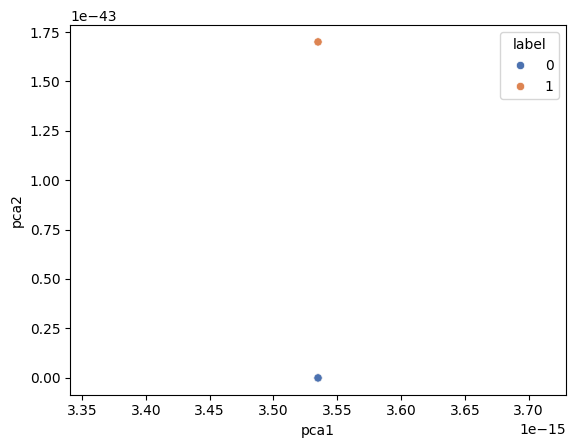

In [65]:
#plot the pca_result with the label as color
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure()
sns.scatterplot(
    x="pca1", y="pca2",
    hue="label",
    palette=sns.color_palette("deep", 2),
    data=pca_result,
    legend="full",
)
